In [1]:
# !pip install --upgrade jaxlib
# !pip install jax==0.4.3
# !pip install jax-numpy-polynomial
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt


# Problem Definition

**Anti-derivative Operator**

Consider the ordinary differential equation (ODE) given by:

$$\frac{ds(x)}{dx}-u(x)=0$$

The solution of our ODE is:

$$G:u(x)→s(x)=s(0)+\int_{0}^{x}u(t)dt$$

$$x\in[0,d_{max}]$$
$$s(0)=0$$

# Auxilliary Functions 

**Sample_Polynomial**

Generates a random polynomial with uniformly random sampled coefficients $c_i\sim \mathcal{U}[-10, 10]$, $\ \ u(x) = \sum_{i=0}^{degree} c_i x^i$

**Inputs:** 

*   **degree** =  degree of the polynomial 
*   **n** = numer of grid points over which polynomial values are given

**Output:** An array of size (n,2), where each row is a sample (x, y).


In [2]:
def sample_polynomial(degree, m_train, key):
    x_values = onp.linspace(d_min, d_max, m_train)
    coefficients = random.uniform(key, shape=(degree + 1,), minval=-10, maxval=10)
    y_values = np.polyval(coefficients, x_values)
    samples = np.column_stack((x_values, y_values))
    return samples


In [3]:
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='black'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x')
  ax1.set_ylabel('u')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)
  

# Initialization of Variables

In [53]:
degree = 5
d_max = 1
d_min = (0) # constant
m = 250 # number of input sensors
x = np.linspace(0, 1, m)
key = random.PRNGKey(0)  # use different key for generating training data and test data 
config.update("jax_enable_x64", True) # Enable double precision

# Demonstration of odeint() Generating a Single Training Data

The polynomial coefficients, given in descending order of power, are:  [ 7.66017952 -7.28532257  3.42724993  4.50473536 -3.0486447   5.1145189 ]


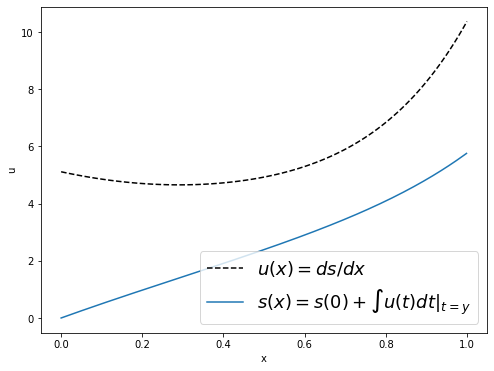

In [6]:
m_train = (degree + 1) 
P_train = 5 

# Sample a random polynomial at `m_train` points on [0 , d_max]
samples = sample_polynomial(degree, m_train, key)
coeffs = np.polyfit(samples[:, 0], samples[:, 1], degree)

# Create a callable polynomial evaluation function 
u_fn = lambda a, b: np.polyval(coeffs, b)

# Input measurements
u = u_fn(coeffs, x)

# Collocation points and labels
y_train = random.uniform(key=key, shape=(P_train*100,), maxval=d_max).sort()
s_train = odeint(u_fn, 0.0, y_train) 

plot_us(x,u,y_train,s_train)

print('The polynomial coefficients, given in descending order of power, are: ', coeffs)


# Data Generating Function

**DeepOnet**

Learn the solution operators of ODE → We will try to approximate ${\cal G}$  (the solution of our ODE operator) by two neural networks:


$$G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{{\cal N}_{B,k}\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{{\cal N}_{T,k}(\textbf{y})}}$$


We want to obtain G, so our goal would be:

 $$\tilde{{\cal G}}_(u)(y)\approx G(u)(y)$$

So we will enforce that condition into a loss function:

$$
\hat{\cal L}_{train}(\theta) = \frac{1}{N_{train}P_{train}}\sum_{i=1}^N\sum_{j=1}^{P_{train}}\left|\int_{0}^{y_j}u_i(t)dt -\tilde{\cal G}(\mathbf u_i)\Big{|}_{y_j}\right|^2
$$

$$
\hat{\cal L}_{train}(\theta) = \frac{1}{N_{train}P_{train}}\sum_{i=1}^N\sum_{j=1}^{P_{train}}\left|\underset{s_{ij}}{\underbrace{\int_{0}^{y_{j}}u_i(t)dt}} -\sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(u_i(x_1),u_i(x_2),\dots,u_i(x_m))\cdot{\cal N}_{\mathrm{T,k}}(y_j)\right|^2.
$$

**Parameters** \\
𝑚 = Number of branch net input sensors

$N_{train}$ = Number of input functions $𝑢_i(𝑥)$ in our training data

$𝑃_{train}$:  Number of collocation points $y_j$

$$\underset{Training \ Data}{\underbrace{u_{train}\in \mathbb{R}^{N_{train}\times𝑃_{train} \ \times \ m}, \ y_{train}\in \mathbb{R}^{N_{train}\times𝑃_{train}}, \ s_{train}\in \mathbb{R}^{N_{train}\times𝑃_{train}}}}$$

We define the test loss function as: 
$$
\hat{\cal L}_{test}(\theta) = \frac{1}{SP_{test}}\sum_{i=1}^S\sum_{j=1}^{P_{test}}\left|\int_{0}^{y_j}u_i(t)dt -\sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(u_i(x_1),u_i(x_2),\dots,u_i(x_m))\cdot{\cal N}_{\mathrm{T,k}}(y_j)\right|^2.
$$

**Parameters** \\

$N_{test}$:  Number of input functions $𝑢_i(𝑥)$ in our test data

$P_{test}$:  Number of points at which we evaluate the antiderivative $\tilde{\cal 𝐺}(𝑢)$ of the test sample u

$$\underset{Test \ Data}{\underbrace{u_{test}\in \mathbb{R}^{N_{test}\times P_{test} \ \times \ m}, \ y_{test}\in \mathbb{R}^{N_{test}\times P_{test}}, \ s_{test}\in \mathbb{R}^{N_{test}\times P_{test}}}}$$

**Note:** both the function $u_i(t)$ and the ODE solution $\int_{0}^{y_j}u_i(t)dt$ are sampled/evaluated in the domain $[0,d_{max}]$.

In [38]:
def generate_data(degree, key, m_train, P, is_training):
  # Sample a random polynomial at `m_train` points on [0 , d_max]
  samples = sample_polynomial(degree, m_train, key)
  coeffs = np.polyfit(samples[:, 0], samples[:, 1], degree)

  # Create a callable polynomial evaluation function 
  u_fn = lambda a, b: np.polyval(coeffs, b)

  # Input measurements
  u = u_fn(0, x)

  if is_training:
      # Collocation points and ODE measurements
      y = random.uniform(key=key, shape=(P,), maxval=d_max).sort()
      s = odeint(u_fn, 0.0, np.hstack((0.0, y)))[1:]
  else:
      # Output sensor locations and ODE measurements
      y = np.linspace(0, d_max, P)
      s = odeint(u_fn, 0.0, y)

  # Tile inputs to match size of y,s
  u = np.tile(u, (P,1))
  
  return u, y, s


# Generate Data 

In [57]:
# Training Data 
N_train = 10000 # number of input functions 
P_train = int(0.75*degree) # number of collocation points (Constant)
m_train = (degree + 1)
config.update("jax_enable_x64", True) # Enable double precision
key_train = random.PRNGKey(0)  # use different keys for generating training data and test data 
keys = random.split(key_train, N_train) # Obtain N_train random numbers
     
gen_fn = jit(lambda key: generate_data(degree, key, m_train, P_train, is_training=True)) 
u_train, y_train, s_train = vmap(gen_fn)(keys)

# # DEBUG
# for i in range(len(u_train)):
#     print("u_train[", i, "]: ", u_train[i])
# for i in range(len(y_train)):
#   print("y_train[", i, "]: ", y_train[i])
# for i in range(len(s_train)):
#   print("s_train[", i, "]: ", s_train[i]) 

#Reshape the data
u_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_train = np.float32(y_train.reshape(N_train * P_train,-1))
s_train = np.float32(s_train.reshape(N_train * P_train,-1))

In [58]:
# Testing Data
N_test = 500 # number of input samples 
P_test = 200 # number of test ODE evaluation points 
m_test = degree*20
key_test = random.PRNGKey(12345) # a different key 
     
keys = random.split(key_test, N_test)
gen_fn = jit(lambda key: generate_data(degree, key, m_test, P_test, is_training=False))
u, y, s = vmap(gen_fn)(keys)

uflat1 = u[0,:]
uflat2 = uflat1[0,:]
print('TEST polynomial coefficients, given in descending order of power, are: ', np.polyfit(x, uflat2, degree))

# # # DEBUG
# for i in range(len(y)):
#     print("u[", i, "]: ", u[i])
# for i in range(len(y)):
#   print("y[", i, "]: ", y[i])
# for i in range(len(y)):
#   print("s[", i, "]: ", s[i])

#Reshape the data
u_test = np.float32(u.reshape(N_test * P_test,-1))
y_test = np.float32(y.reshape(N_test * P_test,-1))
s_test = np.float32(s.reshape(N_test * P_test,-1))

TEST polynomial coefficients, given in descending order of power, are:  [-5.87691144 -1.82640688 -3.72605287  6.06799316 -1.40657233  0.66986433]


In [59]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, batch_size, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements)
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

    # # Number of batches per dataset
    # def __len__(self):
    #     return self.N // self.batch_size


# DeepONet 

In [54]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply
     

In [55]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=relu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()

        # Logger
        self.loss_log = []
        self.test_loss_log = [] # stores the test loss after every 100 iterations

    # Define opeartor net
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs
      
    # Define ODE/PDE residual
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y

    # Define loss
    def loss(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N,1)
        # outputs: s, shape = (N,1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        # print("params:", params)
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        # print("Inputs:", inputs)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                # Compute loss
                loss_value = self.loss(params, batch)
                # Store loss
                self.loss_log.append(loss_value)
                # Print loss during training
                pbar.set_postfix({'Training Loss': loss_value})

                # Compute and store test loss
                params = self.get_params(self.opt_state)
                s_pred = model.predict_s(params, u_test, y_test)[:,None]  
                test_loss = np.mean((s_test - s_pred)**2)/np.mean((s_test)**2)
                self.test_loss_log.append(test_loss)
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

# Evaluate operator

In [63]:
# Initialize model
# For vanilla DeepONet, shallower network yields better accuarcy.
branch_layers = [m, 100, 100] 
trunk_layers =  [1, 100, 100]

model = DeepONet(branch_layers, trunk_layers)
 
# Create data set
batch_size = 5000 
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

# Train
model.train(dataset, nIter=25000)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:,None]  
# s_y_pred = model.predict_s_y(params, u_test, y_test) # remember that s_y=ds/dy=u

# Compute relative l2 error
error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
# error_u = np.linalg.norm(u_test[::P_test].flatten()[:,None] - s_y_pred) / np.linalg.norm(u_test[::P_test].flatten()[:,None])  

print('Optimized DeepONet\'s Average Fractional Test Loss: ', error_s)


100%|██████████| 25000/25000 [52:56<00:00,  7.87it/s, Training Loss=1.963322539650247e-05]


Optimized DeepONet's Average Fractional Test Loss:  0.0014710649755812055


# Visualise results

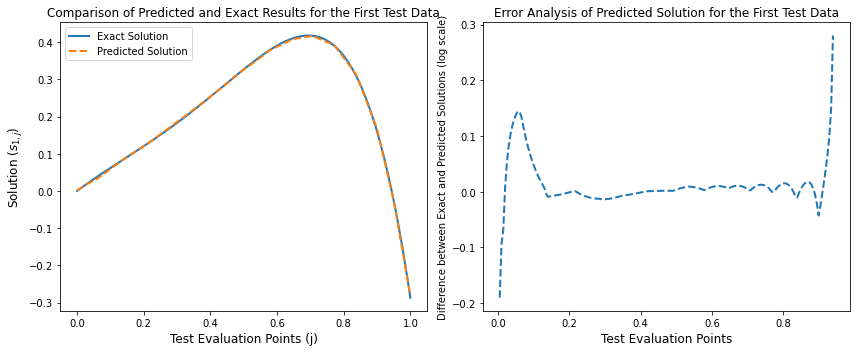

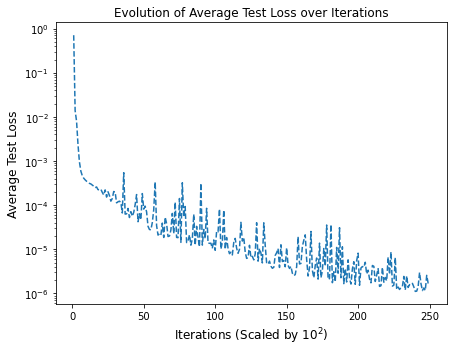

In [64]:
idx = 0 # choose which test data to plot
index = np.arange(idx * P_test,(idx + 1) * P_test)
     
# Compute the relative l2 error for one input sample 
# error_u = np.linalg.norm(s_test[index, :] - s_pred[index, :], 2) / np.linalg.norm(s_test[index, :], 2) 
# error_s = np.linalg.norm(u_test[::P_test][idx].flatten()[:,None] - s_y_pred[index, :], 2) / np.linalg.norm(u_test[::P_test][idx].flatten()[:,None], 2) 

# print("error_u: {:.3e}".format(error_u))
# print("error_s: {:.3e}".format(error_s))

# Visualizations
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact Solution', lw=2) # use 'o-' to show test points
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted Solution', lw=2)
plt.xlabel('Test Evaluation Points (j)', fontsize='large')
plt.ylabel('Solution ($s_{1,j}$)', fontsize='large')
plt.title('Comparison of Predicted and Exact Results for the First Test Data', fontsize='large')
plt.tight_layout()
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], np.log(s_test[index, :]) - np.log(s_pred[index, :]), '--', lw=2, label='error')
plt.xlabel('Test Evaluation Points', fontsize='large')
plt.ylabel('Difference between Exact and Predicted Solutions (log scale)', fontsize='medium')
plt.title('Error Analysis of Predicted Solution for the First Test Data', fontsize='large')
plt.tight_layout()
plt.show()

# Plot test loss per iteration
test_loss_eval_numbers = range(1, len(model.test_loss_log) + 1)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(test_loss_eval_numbers, model.test_loss_log, '--', label='Avg Test loss')
plt.yscale('log')
plt.xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
plt.ylabel('Average Test Loss', fontsize='large')
plt.title('Evolution of Average Test Loss over Iterations', fontsize='large')
plt.tight_layout()
plt.show()

# Predicted residual u(x)
# fig = plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
# plt.plot(y_test[index, :], s_y_pred[index,:], '--', label='Predicted u', lw=2)
# plt.legend()
# plt.tight_layout()

# plt.subplot(1,2,2)
# plt.plot(y_test[index, :], s_y_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
# plt.legend()
# plt.tight_layout()
# plt.show()